In [4]:
import time
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from subprocess import check_output
from util import *
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_pickle('user_product.pkl')

In [5]:
import xgboost
train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)
X_test = data.loc[data.eval_set == "test",:]
# subsample 
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.5, random_state=48)
d_train = xgboost.DMatrix(X_train, y_train)
d_val = xgboost.DMatrix(X_val, y_val,)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 10
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_val, "eval")]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
X_train.shape

(4237330, 37)

[0]	eval-logloss:0.625315
Will train until eval-logloss hasn't improved in 30 rounds.
[10]	eval-logloss:0.333841
[20]	eval-logloss:0.266718
[30]	eval-logloss:0.249776
[40]	eval-logloss:0.245505
[50]	eval-logloss:0.244418
[60]	eval-logloss:0.244033
[70]	eval-logloss:0.243769
[80]	eval-logloss:0.243603
[90]	eval-logloss:0.243464
[100]	eval-logloss:0.243332
[110]	eval-logloss:0.243239
[120]	eval-logloss:0.243129
[130]	eval-logloss:0.243074
[140]	eval-logloss:0.242994
[150]	eval-logloss:0.242933
[160]	eval-logloss:0.242872
[170]	eval-logloss:0.242821
[180]	eval-logloss:0.242787
[190]	eval-logloss:0.242736
[200]	eval-logloss:0.242703
[210]	eval-logloss:0.242684
[220]	eval-logloss:0.242644
[230]	eval-logloss:0.242616
[240]	eval-logloss:0.242601
[250]	eval-logloss:0.242592
[260]	eval-logloss:0.242571
[270]	eval-logloss:0.242564
[280]	eval-logloss:0.242551
[290]	eval-logloss:0.24254
[299]	eval-logloss:0.242534


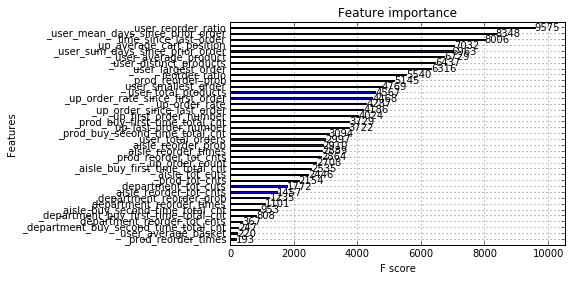

In [7]:
model = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=300, early_stopping_rounds=30, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(model)

In [8]:
sample_submission = pd.read_csv('./data/sample_submission-2.csv')
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [9]:
threshold=0.21
d_test = xgboost.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))
X_test.loc[:,'reordered'] = (model.predict(d_test) > threshold).astype(int)
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)
submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                               group_columns_list=['order_id'],
                                               target_columns_list= ['product_id'],
                                               methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)

submit.columns = sample_submission.columns.tolist()
submit_final = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final.to_csv("python_test.csv", index=False)

add stats features begin ......
add stats features end ......
time lapsing 4.03716683388 s 



In [ ]:
d_train = xgboost.DMatrix(train.drop('reordered', axis=1), train.reordered)

xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 10
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
model_full = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=300, early_stopping_rounds=30, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(model_full)